<a href="https://colab.research.google.com/github/maslory21/Testing/blob/main/homeworks/hw_language_modeling_01_simple/hw_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-12-03 12:00:45--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-12-03 12:00:45 (8.73 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [9]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [22]:
# do not change the code in the block below
# __________start of block__________
batch_size = 3
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [11]:
next(generate_chunk())

array([[83, 53, 76, ..., 13,  1, 67],
       [83, 47, 50, ...,  0, 60, 61],
       [83, 53, 69, ..., 48, 59, 49],
       ...,
       [83,  1, 60, ..., 45, 61, 45],
       [83, 50, 63, ...,  1, 53,  1],
       [83, 56, 50, ...,  0, 47, 58]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [32]:
batch_size = 3
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_solo_chunk():
    start_index = np.random.randint(0, len(text_encoded) - seq_length - 1)
    end_index = start_index + seq_length

    data = np.array(text_encoded[start_index:end_index])

    return np.concatenate((np.array([token_to_idx['<sos>']]), data))




In [35]:
solo_chunk = generate_solo_chunk()
print(solo_chunk)
print(type(solo_chunk))

print(''.join([idx_to_token[x] for x in solo_chunk]))

[83  1 58 50 51 58 59 62 63 53  1 52 45 57 50 63 76  5  0 76  1 50 54  1
 60 59 47 50 61 53 63 73  1 58 50  1 60 59 62 57 50 56 12  0 60 61 53 47
 72 68 55 50  1 57 53 56 59 54  1 58 50  1 49 45 56  1 66 59 49 64 13  0
 62 47 59 75  1 60 59 62 63 72 56 64 75  1 62 47 59 46 59 49 64  0 76  1
 60 59 63 50 61]
<class 'numpy.ndarray'>
<sos> нежности заметя,
я ей поверить не посмел:
привычке милой не дал ходу;
свою постылую свободу
я потер


In [37]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1):
        super(RNN, self).__init__()
        self.input_siz = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)


    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [38]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = token_to_idx[string[c]]
    return Variable(tensor)

print(char_tensor('aboba'))

tensor([18, 19, 31, 19, 18])


In [ ]:
def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [28]:
for chunk in generate_chunk():
    print(chunk)

    for ix in chunk:
      string = ''.join([idx_to_token[x] for x in ix])
      print(string)

[[83  1 74 63 59  1 46 45 61 62 55 53 54  1 55 45 46 53 58 50 63 13  0 52
  49 50 62 73  1 60 59 68 53 47 45 56  1 59 58  5  1 55 59 65 50 54  1 55
  64 69 45 56  5  0 60 61 53 55 45 52 68 53 55 45  1 49 59 55 56 45 49 72
   1 62 56 64 69 45 56  0 53  1 55 58 53 51 55 64  1 60 59 64 63 61 64  1
  68 53 63 45 56]
 [83 81  0 53  1 62 63 45 61 72 54  1 46 45 61 53 58  1 52 49 50 62 73  1
  51 53 47 45 56 13  0 62 59  1 57 58 59 54  5  1 46 72 47 45 56 59  5  1
  47  1 47 59 62 55 61 50 62 50 58 73 50  5  0 52 49 50 62 73  1 60 59 49
   1 59 55 58 59 57  5  1 58 45 49 50 47  1 59 68 55 53  5  0 53 48 61 45
  63 73  1 53 52]
 [83 47 59 56 53 56  1 47  1 49 64 61 45 68 55 53  7  0 49 45 54  1 46 59
  48  1 49 64 69 50  1 50 48 59  1 62 60 45 62 50 58 73 50  5  0 45  1 55
  59 62 63 59 68 55 45 57  1 50 48 59  1 60 59 55 59 54  0 47  1 57 59 48
  53 56 50  5  1 47  1 57 45 63 73  6 52 50 57 56 50  1 62 72 61 59 54  2
  44  0  0  0  0]]
<sos> это барский кабинет;
здесь почивал он, кофей кушал,

In [20]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

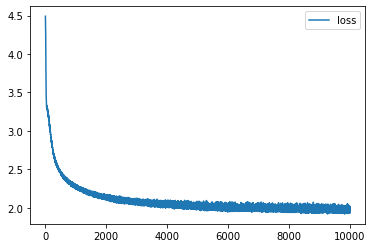

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

На этом задание завершено. Поздравляем!